In [1]:
## check out convolution with gaussian to create weighted centroiding

Testing Gaussian-smoothed image as weights for centroid calculation...


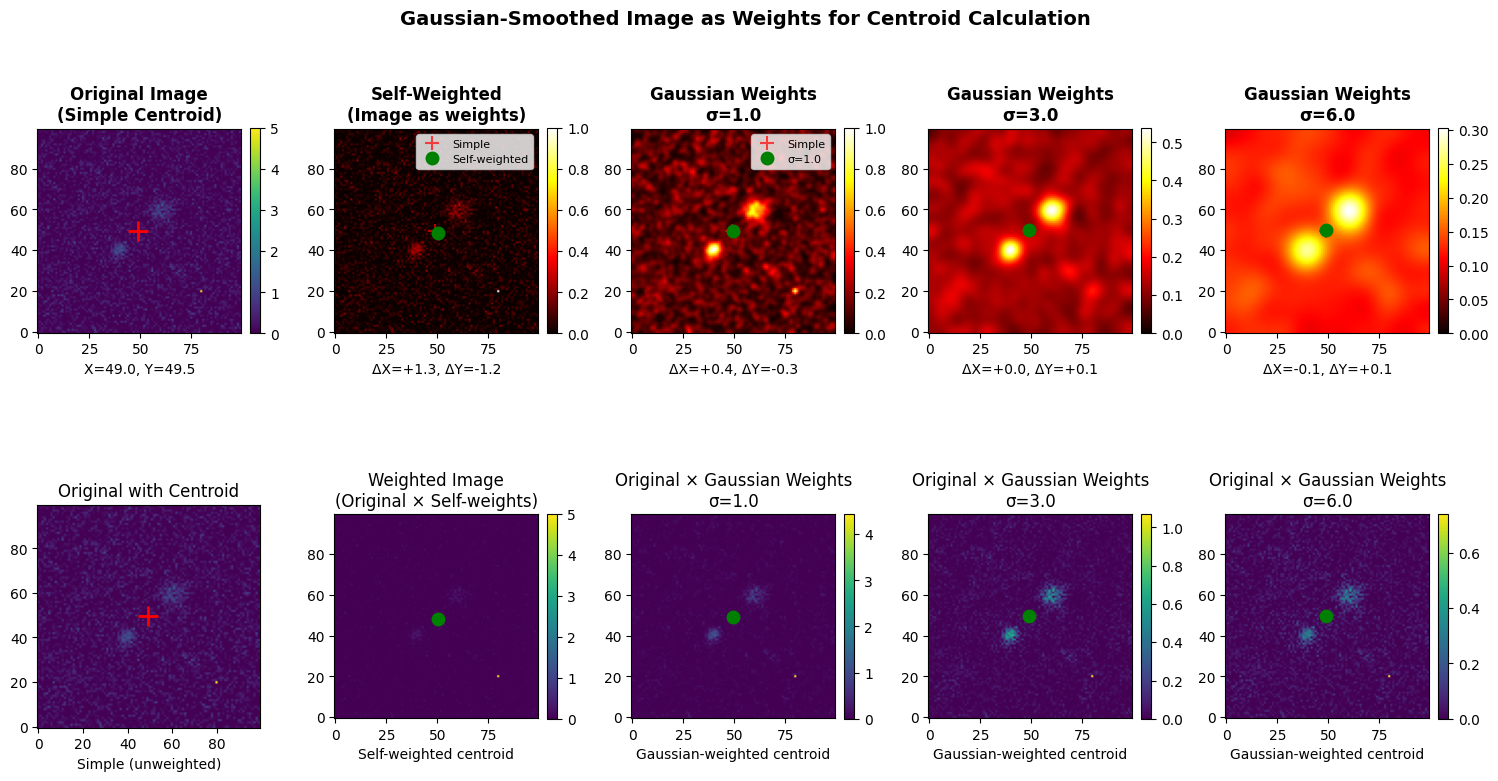

QUANTITATIVE COMPARISON

Simple centroid (unweighted):
  X = 49.04, Y = 49.51

Self-weighted centroid (image as weights):
  X = 50.33, Y = 48.27
  Shift from simple: ΔX = +1.28, ΔY = -1.24
  Distance: 1.79 pixels

Gaussian-weighted centroids:

  σ = 1.0:
    X = 49.46, Y = 49.20
    Shift: ΔX = +0.41, ΔY = -0.31
    Distance from simple: 0.52 pixels
    Distance from self-weighted: 1.27 pixels

  σ = 3.0:
    X = 49.07, Y = 49.63
    Shift: ΔX = +0.02, ΔY = +0.12
    Distance from simple: 0.12 pixels
    Distance from self-weighted: 1.86 pixels

  σ = 6.0:
    X = 48.90, Y = 49.63
    Shift: ΔX = -0.15, ΔY = +0.12
    Distance from simple: 0.19 pixels
    Distance from self-weighted: 1.98 pixels

SCENARIO TESTING

Asymmetric:
----------------------------------------
  Simple: X=46.0, Y=46.0
  Gaussian (σ=3): X=43.1, Y=43.1
  Shift: 4.09 pixels


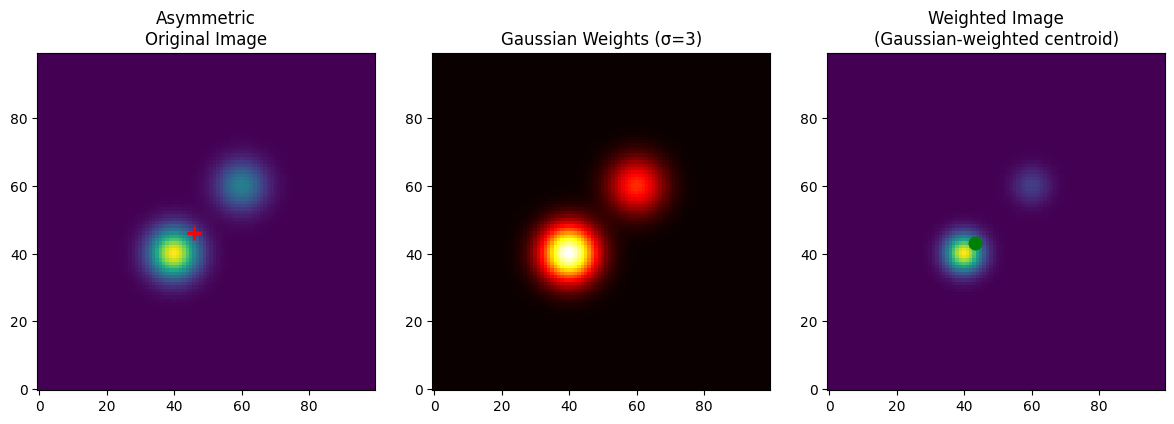


Noisy:
----------------------------------------
  Simple: X=49.3, Y=49.4
  Gaussian (σ=3): X=49.4, Y=49.5
  Shift: 0.07 pixels


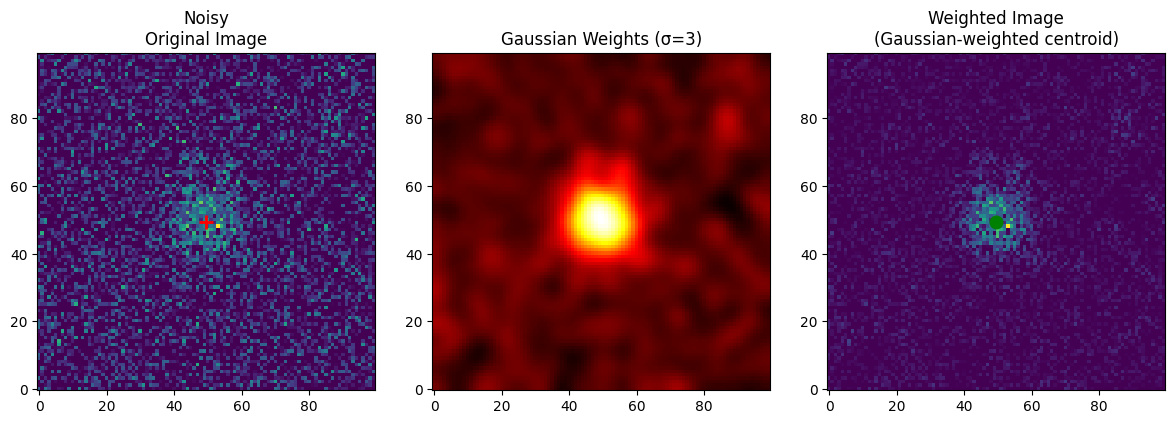


With Outlier:
----------------------------------------
  Simple: X=50.2, Y=49.8
  Gaussian (σ=3): X=50.0, Y=50.0
  Shift: 0.28 pixels


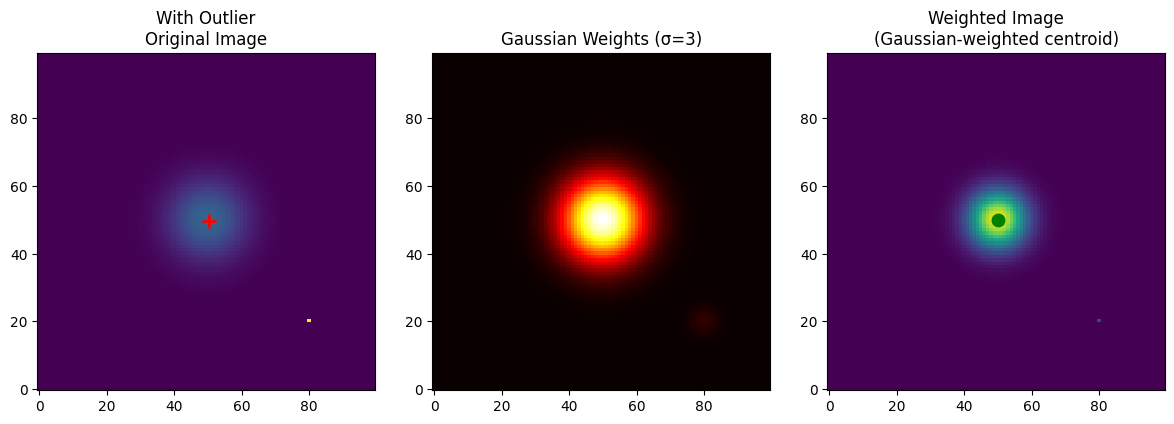


Multiple Objects:
----------------------------------------
  Simple: X=50.0, Y=43.3
  Gaussian (σ=3): X=50.0, Y=43.3
  Shift: 0.00 pixels


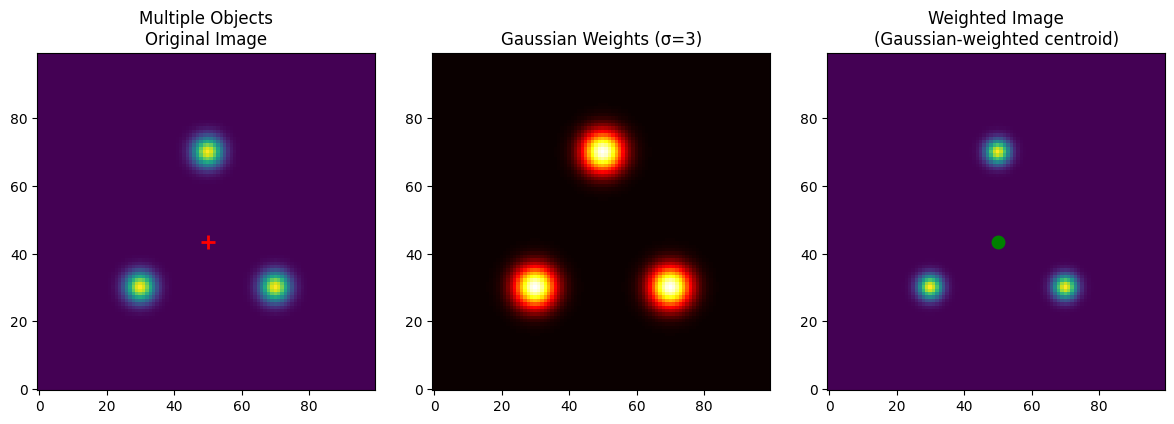

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# ============================================
# CREATE TEST IMAGE
# ============================================
def create_test_image():
    """Create a test image with multiple objects and noise"""
    size = 100
    image = np.zeros((size, size))
    y, x = np.indices((size, size))
    
    # Add multiple Gaussian-like objects
    objects = [
        {'center': (40, 40), 'amplitude': 1.0, 'sigma': 3},
        {'center': (60, 60), 'amplitude': 0.8, 'sigma': 4},
        {'center': (30, 70), 'amplitude': 0.5, 'sigma': 2},
    ]
    
    for obj in objects:
        cy, cx = obj['center']
        sigma = obj['sigma']
        amplitude = obj['amplitude']
        r2 = (x - cx)**2 + (y - cy)**2
        image += amplitude * np.exp(-r2 / (2 * sigma**2))
    
    # Add noise
    noise = 0.3 * np.random.randn(size, size)
    image += noise
    image = np.clip(image, 0, None)  # Remove negative values
    
    # Add a hot pixel outlier
    image[20, 80] = 5.0
    
    return image

# ============================================
# CENTROID CALCULATION METHODS
# ============================================
def simple_centroid(image):
    """Standard unweighted centroid"""
    y, x = np.indices(image.shape)
    total = np.sum(image)
    if total == 0:
        return np.array(image.shape) / 2
    cy = np.sum(y * image) / total
    cx = np.sum(x * image) / total
    return cy, cx

def weighted_centroid(image, weights):
    """Weighted centroid using provided weights"""
    y, x = np.indices(image.shape)
    total_weight = np.sum(weights * image)
    if total_weight == 0:
        return simple_centroid(image)
    cy = np.sum(y * weights * image) / total_weight
    cx = np.sum(x * weights * image) / total_weight
    return cy, cx

def gaussian_weighted_centroid(image, sigma):
    """
    Your proposed method:
    1. Create weights by smoothing the image with Gaussian
    2. Use these weights to calculate weighted centroid of ORIGINAL image
    """
    # Step 1: Create weights by smoothing the image
    weights = gaussian_filter(image, sigma=sigma)
    
    # Step 2: Use weights for weighted centroid of original image
    cy, cx = weighted_centroid(image, weights)
    
    return cy, cx, weights

# ============================================
# VISUALIZE AND COMPARE
# ============================================
def visualize_comparison():
    """Compare different centroid calculation methods"""
    
    # Create test image
    image = create_test_image()
    
    # Calculate centroids
    cy_simple, cx_simple = simple_centroid(image)
    
    # Test different sigma values for Gaussian weighting
    sigmas = [1.0, 3.0, 6.0]
    results = []
    
    for sigma in sigmas:
        cy_gauss, cx_gauss, weights = gaussian_weighted_centroid(image, sigma)
        results.append({
            'sigma': sigma,
            'centroid': (cy_gauss, cx_gauss),
            'weights': weights
        })
    
    # Create visualization
    fig, axes = plt.subplots(2, len(sigmas) + 2, figsize=(15, 8))
    
    # Row 1: Image and weights
    # Column 0: Original image
    ax = axes[0, 0]
    im = ax.imshow(image, cmap='viridis', origin='lower')
    ax.plot(cx_simple, cy_simple, 'r+', markersize=15, markeredgewidth=2)
    ax.set_title('Original Image\n(Simple Centroid)', fontweight='bold')
    ax.set_xlabel(f'X={cx_simple:.1f}, Y={cy_simple:.1f}')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Column 1: Simple centroid weighted by itself (for comparison)
    ax = axes[0, 1]
    weights_self = image / np.max(image)  # Normalized self-weights
    cy_self, cx_self = weighted_centroid(image, weights_self)
    im = ax.imshow(weights_self, cmap='hot', origin='lower')
    ax.plot(cx_simple, cy_simple, 'r+', markersize=10, markeredgewidth=1.5, alpha=0.7, label='Simple')
    ax.plot(cx_self, cy_self, 'go', markersize=8, markeredgewidth=2, label='Self-weighted')
    ax.set_title('Self-Weighted\n(Image as weights)', fontweight='bold')
    ax.set_xlabel(f'ΔX={cx_self-cx_simple:+.1f}, ΔY={cy_self-cy_simple:+.1f}')
    ax.legend(fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Gaussian-weighted results
    for i, sigma in enumerate(sigmas):
        ax = axes[0, i + 2]
        weights = results[i]['weights']
        cy, cx = results[i]['centroid']
        
        im = ax.imshow(weights, cmap='hot', origin='lower', vmin=0, vmax=np.max(weights))
        ax.plot(cx_simple, cy_simple, 'r+', markersize=10, markeredgewidth=1.5, alpha=0.7, label='Simple')
        ax.plot(cx, cy, 'go', markersize=8, markeredgewidth=2, label=f'σ={sigma}')
        ax.set_title(f'Gaussian Weights\nσ={sigma}', fontweight='bold')
        ax.set_xlabel(f'ΔX={cx-cx_simple:+.1f}, ΔY={cy-cy_simple:+.1f}')
        
        if i == 0:
            ax.legend(fontsize=8)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Row 2: Weighted images and centroids
    # Column 0: Original with simple centroid
    ax = axes[1, 0]
    im = ax.imshow(image, cmap='viridis', origin='lower')
    ax.plot(cx_simple, cy_simple, 'r+', markersize=15, markeredgewidth=2)
    ax.set_title('Original with Centroid')
    ax.set_xlabel('Simple (unweighted)')
    
    # Column 1: Weighted image = original * self-weights
    ax = axes[1, 1]
    weighted_img_self = image * weights_self
    im = ax.imshow(weighted_img_self, cmap='viridis', origin='lower')
    ax.plot(cx_self, cy_self, 'go', markersize=8, markeredgewidth=2)
    ax.set_title('Weighted Image\n(Original × Self-weights)')
    ax.set_xlabel('Self-weighted centroid')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Gaussian-weighted images
    for i, sigma in enumerate(sigmas):
        ax = axes[1, i + 2]
        weights = results[i]['weights']
        cy, cx = results[i]['centroid']
        
        # Weighted image = original × Gaussian weights
        weighted_img = image * weights
        
        im = ax.imshow(weighted_img, cmap='viridis', origin='lower')
        ax.plot(cx, cy, 'go', markersize=8, markeredgewidth=2)
        ax.set_title(f'Original × Gaussian Weights\nσ={sigma}')
        ax.set_xlabel('Gaussian-weighted centroid')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.suptitle('Gaussian-Smoothed Image as Weights for Centroid Calculation', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.show()
    
    # ============================================
    # QUANTITATIVE ANALYSIS
    # ============================================
    print("=" * 70)
    print("QUANTITATIVE COMPARISON")
    print("=" * 70)
    print(f"\nSimple centroid (unweighted):")
    print(f"  X = {cx_simple:.2f}, Y = {cy_simple:.2f}")
    
    print(f"\nSelf-weighted centroid (image as weights):")
    print(f"  X = {cx_self:.2f}, Y = {cy_self:.2f}")
    print(f"  Shift from simple: ΔX = {cx_self-cx_simple:+.2f}, ΔY = {cy_self-cy_simple:+.2f}")
    print(f"  Distance: {np.sqrt((cx_self-cx_simple)**2 + (cy_self-cy_simple)**2):.2f} pixels")
    
    print("\nGaussian-weighted centroids:")
    for i, sigma in enumerate(sigmas):
        cy, cx = results[i]['centroid']
        shift_x = cx - cx_simple
        shift_y = cy - cy_simple
        distance = np.sqrt(shift_x**2 + shift_y**2)
        
        print(f"\n  σ = {sigma}:")
        print(f"    X = {cx:.2f}, Y = {cy:.2f}")
        print(f"    Shift: ΔX = {shift_x:+.2f}, ΔY = {shift_y:+.2f}")
        print(f"    Distance from simple: {distance:.2f} pixels")
        
        # Compare with self-weighted
        dist_from_self = np.sqrt((cx - cx_self)**2 + (cy - cy_self)**2)
        print(f"    Distance from self-weighted: {dist_from_self:.2f} pixels")

# ============================================
# TEST WITH DIFFERENT SCENARIOS
# ============================================
def test_scenarios():
    """Test the method with different challenging scenarios"""
    
    print("\n" + "=" * 70)
    print("SCENARIO TESTING")
    print("=" * 70)
    
    size = 100
    y, x = np.indices((size, size))
    
    scenarios = {
        'Asymmetric': None,
        'Noisy': None,
        'With Outlier': None,
        'Multiple Objects': None,
    }
    
    # Scenario 1: Asymmetric Gaussian
    cx1, cy1 = 40, 40
    cx2, cy2 = 60, 60
    r2_1 = (x - cx1)**2 + (y - cy1)**2
    r2_2 = (x - cx2)**2 + (y - cy2)**2
    scenarios['Asymmetric'] = 0.7*np.exp(-r2_1/(2*5**2)) + 0.3*np.exp(-r2_2/(2*5**2))
    
    # Scenario 2: Noisy
    clean = np.exp(-((x-50)**2 + (y-50)**2) / (2*8**2))
    scenarios['Noisy'] = clean + 0.5*np.random.randn(size, size)
    scenarios['Noisy'] = np.clip(scenarios['Noisy'], 0, None)
    
    # Scenario 3: With outlier
    scenarios['With Outlier'] = clean.copy()
    scenarios['With Outlier'][20, 80] = 3.0  # Bright outlier
    
    # Scenario 4: Multiple separate objects
    scenarios['Multiple Objects'] = np.zeros((size, size))
    centers = [(30, 30), (70, 30), (50, 70)]
    for cx, cy in centers:
        r2 = (x - cx)**2 + (y - cy)**2
        scenarios['Multiple Objects'] += np.exp(-r2 / (2*3**2))
    
    # Test each scenario
    for name, image in scenarios.items():
        print(f"\n{name}:")
        print("-" * 40)
        
        cy_simple, cx_simple = simple_centroid(image)
        print(f"  Simple: X={cx_simple:.1f}, Y={cy_simple:.1f}")
        
        # Test Gaussian weighting with sigma=3
        cy_gauss, cx_gauss, _ = gaussian_weighted_centroid(image, sigma=3)
        shift = np.sqrt((cx_gauss-cx_simple)**2 + (cy_gauss-cy_simple)**2)
        print(f"  Gaussian (σ=3): X={cx_gauss:.1f}, Y={cy_gauss:.1f}")
        print(f"  Shift: {shift:.2f} pixels")
        
        # Show what the weights look like
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        axes[0].imshow(image, cmap='viridis', origin='lower')
        axes[0].plot(cx_simple, cy_simple, 'r+', markersize=10, markeredgewidth=2)
        axes[0].set_title(f'{name}\nOriginal Image')
        
        weights = gaussian_filter(image, sigma=3)
        axes[1].imshow(weights, cmap='hot', origin='lower')
        axes[1].set_title('Gaussian Weights (σ=3)')
        
        weighted_img = image * weights
        axes[2].imshow(weighted_img, cmap='viridis', origin='lower')
        axes[2].plot(cx_gauss, cy_gauss, 'go', markersize=8, markeredgewidth=2)
        axes[2].set_title('Weighted Image\n(Gaussian-weighted centroid)')
        
        plt.tight_layout()
        plt.show()

# ============================================
# MAIN EXECUTION
# ============================================
if __name__ == "__main__":
    print("Testing Gaussian-smoothed image as weights for centroid calculation...")
    visualize_comparison()
    test_scenarios()